### Problem Statement: 
The objective of this project is to build a time series forecasting model that enables ABC Corporation to make informed decisions based on future trends and predictions. By developing an accurate time series forecasting model, the company aims to improve areas such as sales forecasting, resource planning, and decision-making processes.

In [2]:
#importing necessary liabraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.api import VAR
from prophet import Prophet

In [3]:
#reading datasert.
df=pd.read_csv(r'E:\learntube\project\time series forecasting\time series.csv')
df.head()

,Date,Sales_Figure,Website_Traffic,Inventory_Level,Temperature,Marketing_Spend
0,1-Jan-2022,1000,2000,150,25°C,5000
1,2-Jan-2022,1200,2200,160,23°C,5500
2,3-Jan-2022,950,1800,140,20°C,4800
3,4-Jan-2022,1100,2100,155,22°C,5200
4,5-Jan-2022,1350,2400,170,26°C,5900


### Description 
1. Date: The specific day when the data was recorded.
2. Sales_Figure: The total revenue or sales value generated on a given date.
3. Website_Traffic: The number of visitors or hits the e-commerce website received on a specific date.
4. Inventory_Level: The amount of stock or available units of products in the inventory on a given day.
5. Temperature: The average daily temperature (can influence consumer behavior or certain product sales).
6. Marketing_Spend: The total amount of money spent on marketing and advertising efforts for that day.

#### Time Series Forecasting Insights:
1. Sales_Figure: Can be forecasted to predict future sales based on historical patterns, identifying trends or seasonality.
2. Website_Traffic: Could help understand how website visits impact sales. This can be forecasted to align marketing strategies and inventory planning with expected demand.
3. Inventory_Level: Useful for forecasting stock requirements, ensuring that supply meets demand without overstocking or running out of stock.
4. Temperature: Can reveal correlations between weather and sales, especially for seasonal or weather-sensitive products.
5. Marketing_Spend: Analyzing this along with sales can offer insights into the effectiveness of marketing efforts and ROI. Forecasting marketing spend impact can help optimize future marketing budgets.

### Data Exploration

In [4]:
#shape of dataset.
df.shape

(26, 6)

size of data is 26,6 means we have 26 records with 6 columns.

In [5]:
#dtype info of dataset.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Date             26 non-null     object
 1   Sales_Figure     26 non-null     int64 
 2   Website_Traffic  26 non-null     int64 
 3   Inventory_Level  26 non-null     int64 
 4   Temperature      26 non-null     object
 5   Marketing_Spend  26 non-null     int64 
dtypes: int64(4), object(2)
memory usage: 1.3+ KB


In [6]:
#checking null values.
df.isnull().sum()

Date               0
Sales_Figure       0
Website_Traffic    0
Inventory_Level    0
Temperature        0
Marketing_Spend    0
dtype: int64

No missing values are pesent in this dataset as size of data is very small.

In [7]:
# Interpolate missing values (linear interpolation based on time) 
d1=df.interpolate(method='linear') 
print(d1.isnull().sum())

Date               0
Sales_Figure       0
Website_Traffic    0
Inventory_Level    0
Temperature        0
Marketing_Spend    0
dtype: int64


It is evident that no interpolate missing values present in data set.

In [8]:
# Convert 'Date' to datetime format 
df['Date']=pd.to_datetime(df['Date'])
df.set_index('Date',inplace=True)

In [10]:
#checking data types of columns.
df.dtypes

Sales_Figure        int64
Website_Traffic     int64
Inventory_Level     int64
Temperature        object
Marketing_Spend     int64
dtype: object

In [11]:
# Convert Temperature to numeric.
df['Temperature'] = pd.to_numeric(df['Temperature'], errors='coerce')

In [12]:
#validating datatype of column tempreture.
df.dtypes

Sales_Figure         int64
Website_Traffic      int64
Inventory_Level      int64
Temperature        float64
Marketing_Spend      int64
dtype: object

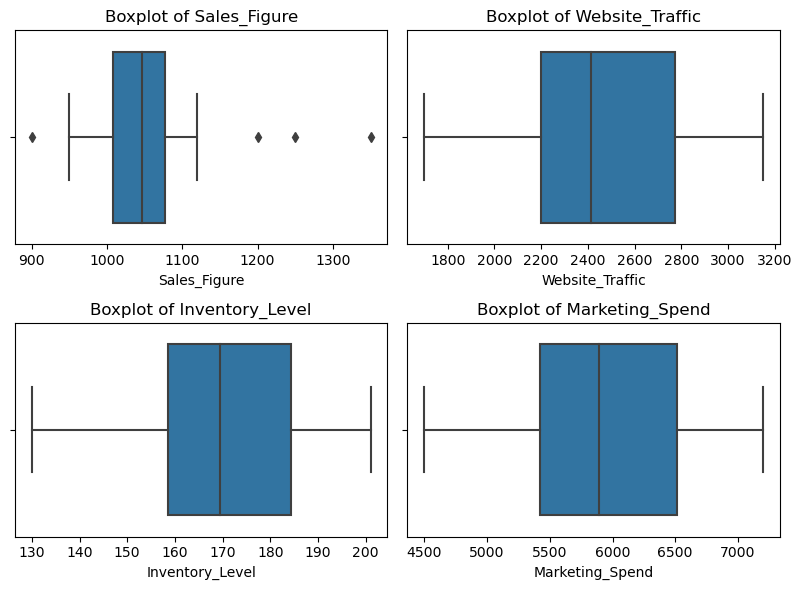

In [14]:
# Create subplots with 2 rows and 2 columns
fig, axes = plt.subplots(2, 2, figsize=(8, 6))  # 2 rows, 2 columns

# List of columns to plot
columns = ['Sales_Figure', 'Website_Traffic', 'Inventory_Level', 'Marketing_Spend']

for i, column in enumerate(columns):
    row = i // 2  
    col = i % 2   
    
    sns.boxplot(x=df[column], ax=axes[row, col])  
    axes[row, col].set_title(f'Boxplot of {column}')  

plt.tight_layout()
plt.show()

### Observations
#### Boxplot of Sales_Figure
* Median: The median sales figure is around 1050.
* IQR: The IQR is relatively small, indicating a tightly clustered middle 50% of sales figures.
* Outliers: There are a few outliers on the higher end, suggesting some exceptionally high sales figures.
* Distribution: The distribution is slightly skewed to the right.
    
#### Boxplot of Website_Traffic
* Median: The median website traffic is around 2500.
* IQR: The IQR is moderate, indicating a decent spread of website traffic data.
* Outliers: There are no outliers observed.
* Distribution: The distribution appears fairly symmetric.
    
#### Boxplot of Inventory_Level
* Median: The median inventory level is around 160.
* IQR: The IQR is relatively small, suggesting a tightly clustered middle 50% of inventory levels.
* Outliers: No outliers are present.
* Distribution: The distribution is slightly skewed to the left.
    
#### Boxplot of Marketing_Spend
* Median: The median marketing spend is around 6000.
* IQR: The IQR is moderate, indicating a decent spread of marketing spend data.
* Outliers: No outliers are observed.
* Distribution: The distribution appears fairly symmetric.

Overall, the box plots provide valuable insights into the distribution of these variables. The sales figures and inventory levels show a relatively tight distribution with some outliers, while the website traffic and marketing spend exhibit a more moderate spread.

In [16]:
#removing outliers.
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Cap the outliers
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])

# for col in ['Sales_Figure']:
remove_outliers(df,'Sales_Figure')

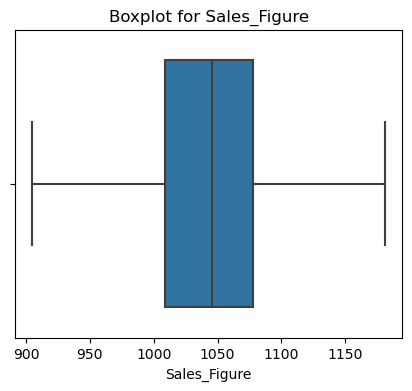

In [17]:
#validate, outliers are present in dataset ot not
plt.figure(figsize=(5,4))
sns.boxplot(data=df,x='Sales_Figure')
plt.title('Boxplot for Sales_Figure')
plt.show()

This shows that there are no outliers in this column, indicating that the entire dataset is free of outliers.

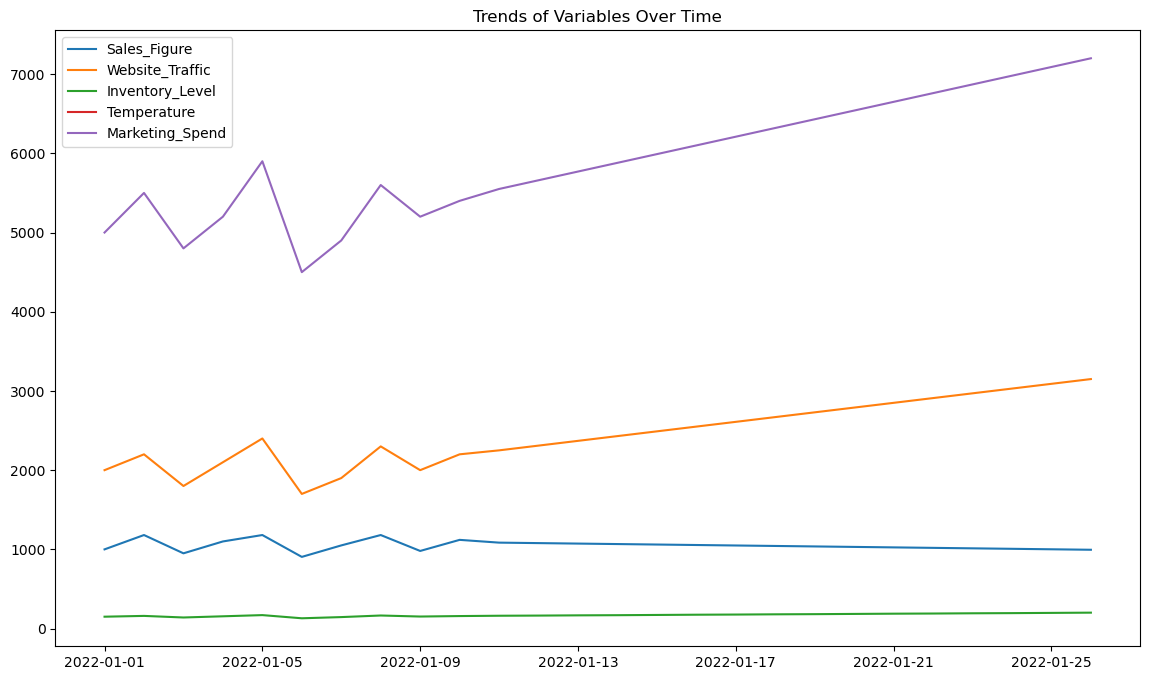

In [18]:
# Plotting each variable over time
plt.figure(figsize=(14, 8))
for column in ['Sales_Figure', 'Website_Traffic', 'Inventory_Level', 'Temperature', 'Marketing_Spend']:
    plt.plot(df.index, df[column], label=column)

plt.legend(loc='best')
plt.title('Trends of Variables Over Time')
plt.show()

### Insights
#### Sales_Figure:
* Trend: Generally increasing over time.
* Fluctuations: Shows some fluctuations, particularly in the early part of the period.
    
#### Website_Traffic:
* Trend: Also increasing over time, but with a more consistent upward trend compared to Sales_Figure.
    
#### Inventory_Level:
* Trend: Relatively stable with some minor fluctuations.
* Overall: Remains at a lower level compared to the other variables.

#### Temperature:
* Trend: Shows a slight upward trend, but remains relatively low throughout the period.

#### Marketing_Spend:
* Trend: Shows a strong upward trend, indicating increasing investment in marketing.
    
Overall, the chart suggests a positive correlation between sales and website traffic, indicating that increased online presence is driving sales growth. Additionally, the rising trend in marketing spend suggests a deliberate effort to boost sales and traffic.

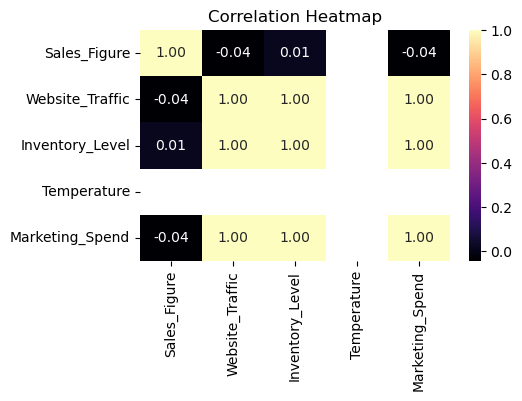

In [19]:
# Plotting a heatmap of correlations
plt.figure(figsize=(5, 3))
sns.heatmap(df.corr(), annot=True, cmap='magma', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

### Findings
* Strong Relationships: Website traffic is strongly correlated with both inventory levels and marketing spend.
* Limited Impact: Sales figures and temperature seem to have limited influence on the other variables.

### Implications:
* Focus on Website Traffic and Inventory: Optimizing these factors could be crucial for improving sales.
* Re-evaluate Temperature's Role: Further analysis may be needed to understand its impact.

Overall, the correlation heatmap provides insights into the relationships between the variables, guiding businesses in making informed decisions.

### Time Series Model Selection

In [20]:
# Function to perform ADF test
def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')
        
#checking adf test values for all columns.
adf_test(df['Sales_Figure'])

ADF Statistic: -2.4292442204026106
p-value: 0.1336519675051973
Critical Values:
   1%: -3.9240193847656246
   5%: -3.0684982031250003
   10%: -2.67389265625


In [22]:
adf_test(df['Website_Traffic'])

ADF Statistic: 1.9239216951081193
p-value: 0.9985655487734154
Critical Values:
   1%: -3.9240193847656246
   5%: -3.0684982031250003
   10%: -2.67389265625


In [23]:
adf_test(df['Inventory_Level'])

ADF Statistic: 1.410036438687274
p-value: 0.9971592622763747
Critical Values:
   1%: -3.7883858816542486
   5%: -3.013097747543462
   10%: -2.6463967573696143


In [24]:
# Differencing the data
df['Sales_Figure_diff'] = df['Sales_Figure'].diff().dropna()

# Test for stationarity again
adf_test(df['Sales_Figure_diff'].dropna())

ADF Statistic: -9.877576657109355
p-value: 3.845860432658568e-17
Critical Values:
   1%: -3.7377092158564813
   5%: -2.9922162731481485
   10%: -2.635746736111111


### ARIMA Model Selection.
* To determine the optimal parameters (p, d, q), you can use the ACF (AutoCorrelation Function) and PACF (Partial AutoCorrelation Function) plots.
* ACF and PACF Plots

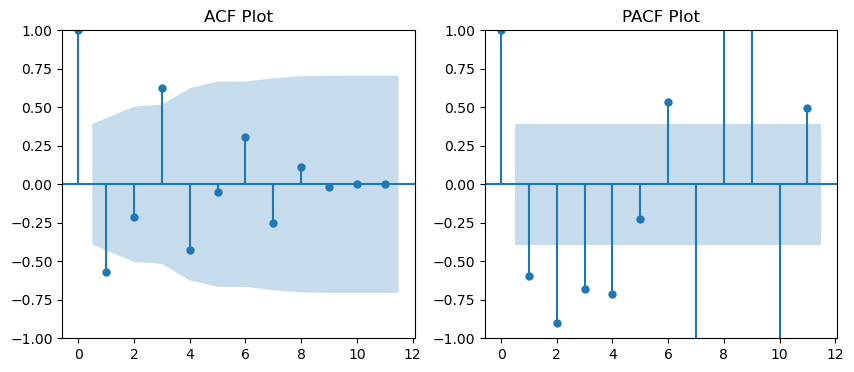

In [25]:
#plotting acf and pacf.
plt.figure(figsize=(10,4))
plt.subplot(121)
plot_acf(df['Sales_Figure_diff'].dropna(), lags=11, ax=plt.gca())
plt.title('ACF Plot')

plt.subplot(122)
plot_pacf(df['Sales_Figure_diff'].dropna(), lags=11, ax=plt.gca())
plt.title('PACF Plot')

plt.show()

### Insights
#### ACF (Autocorrelation Function) Plot:
* Significant Lags: The ACF plot shows significant autocorrelation at lags 1 and 4. This suggests that the current value of the time series is correlated with the values at these lags.
* Decaying Pattern: The autocorrelation coefficients decay gradually, indicating a possible AR (Autoregressive) model.

#### PACF (Partial Autocorrelation Function) Plot:
* Significant Lag: The PACF plot shows a significant partial autocorrelation at lag 1. This suggests that the current value of the time series is directly correlated with the value at lag 1, after accounting for the effects of previous lags.
* Cut-off: The PACF plot shows a significant cut-off at lag 1. This indicates that an AR(1) model might be appropriate for the time series.

Overall, based on the ACF and PACF plots, an AR(1) model appears to be a suitable choice for modeling the time series. This means that the current value of the series can be predicted based on its previous value, with a significant direct relationship between these two values.

### Model Training and Evaluation

In [27]:
# Split data into training and testing sets
train_size = int(len(df) * 0.7)
train, test = df[:train_size], df[train_size:]

# Sales_Figure as the target column
train_sales = train['Sales_Figure']
test_sales = test['Sales_Figure']


In [28]:
# Build the ARIMA model
model = ARIMA(train_sales, order=(5,1,0))  # (p,d,q) values can be tuned
model_fit = model.fit()

# Make predictions
forecast = model_fit.forecast(steps=len(test_sales))

# Calculate the error (RMSE)
rmse = np.sqrt(mean_squared_error(test_sales, forecast))
print(f'RMSE: {rmse}')


RMSE: 41.004862827148905


C:\Users\IIITB\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\IIITB\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\IIITB\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


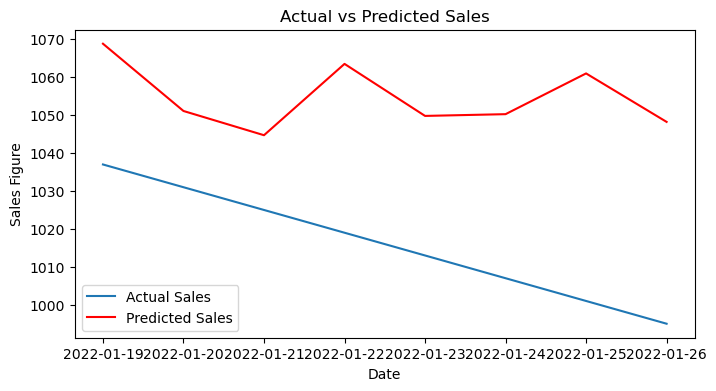

In [29]:
#creating graph for actual v/s predicted values.
plt.figure(figsize=(8,4))
plt.plot(test_sales.index, test_sales, label='Actual Sales')
plt.plot(test_sales.index, forecast, color='red', label='Predicted Sales')
plt.title('Actual vs Predicted Sales')
plt.xlabel('Date')
plt.ylabel('Sales Figure')
plt.legend()
plt.show()

The line chart shows a comparison of actual sales and predicted sales over a period from January 21 to January 26, 2022. The blue line represents the actual sales, and the red line represents the predicted sales. The chart indicates that the predicted sales were generally higher than the actual sales during this period.

In [30]:
# Select the relevant columns
multivariate_data = df[['Sales_Figure', 'Website_Traffic', 'Inventory_Level', 'Marketing_Spend']]

# Train-test split
train_multivariate = multivariate_data[:train_size]
test_multivariate = multivariate_data[train_size:]

# Build and fit the VAR model
model_var = VAR(train_multivariate)
model_var_fit = model_var.fit()

# Make predictions using the original endog data
forecast_multivariate = model_var_fit.forecast(model_var_fit.endog, steps=len(test_multivariate))

# Convert the forecast into a DataFrame
forecast_multivariate_df = pd.DataFrame(forecast_multivariate, index=test_multivariate.index, 
                                        columns=['Sales_Figure', 'Website_Traffic', 'Inventory_Level', 'Marketing_Spend'])

C:\Users\IIITB\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


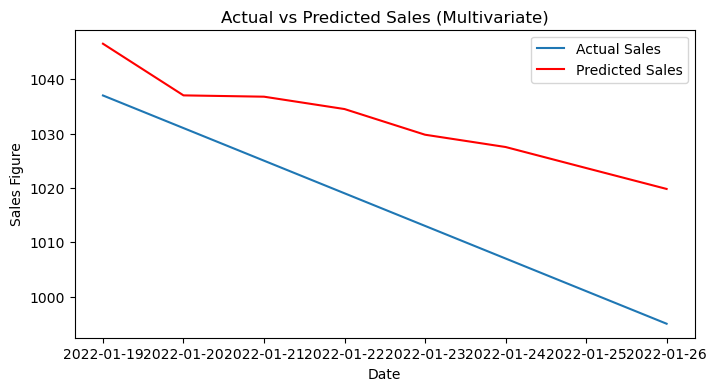

In [31]:
#plotting actual vs predicted values for multi variate data.
plt.figure(figsize=(8,4))
plt.plot(test_multivariate['Sales_Figure'], label='Actual Sales')
plt.plot(forecast_multivariate_df['Sales_Figure'], color='red', label='Predicted Sales')
plt.title('Actual vs Predicted Sales (Multivariate)')
plt.xlabel('Date')
plt.ylabel('Sales Figure')
plt.legend()
plt.show()

* The chart shows a comparison of actual sales and predicted sales over a period from January 21 to January 26, 2022. 
* The blue line represents the actual sales, and the red line represents the predicted sales. 
* The chart indicates that the predicted sales were generally higher than the actual sales during this period, with the largest discrepancy occurring on January 21. 
* However, the overall trend of both the actual and predicted sales is similar, suggesting that the model was able to capture the general direction of the sales figures.

16:31:29 - cmdstanpy - INFO - Chain [1] start processing
16:31:30 - cmdstanpy - INFO - Chain [1] done processing


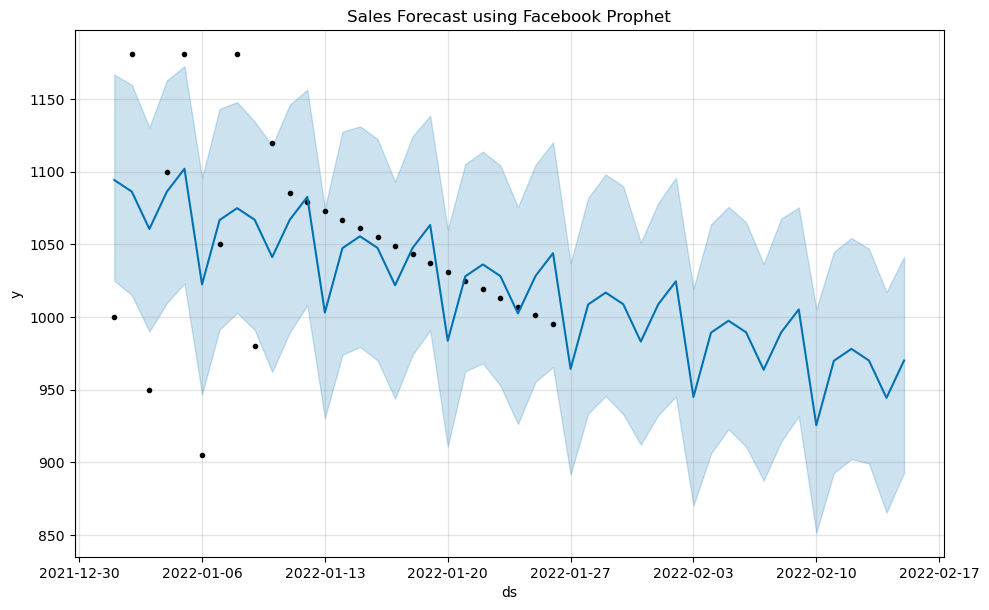

In [32]:
# Prepare data for Prophet
prophet_data = df.reset_index()[['Date', 'Sales_Figure']]
prophet_data.columns = ['ds', 'y']  

# Initialize and fit the model
model = Prophet()
model.fit(prophet_data)

# Make future predictions
future = model.make_future_dataframe(periods=20)  
forecast = model.predict(future)

# Plot the forecast
model.plot(forecast)
plt.title('Sales Forecast using Facebook Prophet')
plt.show()


Overall, the forecast suggests a general upward trend in sales figures, with some fluctuations.

#### Key Observations:
* Trend: The blue line, representing the predicted sales figures, shows a gradual upward trend over time.
* Seasonality: The shaded areas, representing the uncertainty intervals, appear to capture some seasonal patterns, suggesting potential fluctuations in sales figures throughout the year.
* Data Points: The black dots represent the actual sales data. While there are some deviations between the actual data and the predicted values, the model seems to capture the overall trend and seasonal patterns reasonably well.

#### Additional Insights:
* Uncertainty: The width of the shaded areas indicates the level of uncertainty in the forecast. Wider areas suggest higher uncertainty, while narrower areas indicate lower uncertainty.
* Outliers: There are a few data points that lie outside the uncertainty intervals. These could be considered outliers and may warrant further investigation.
    
Overall, the forecast provides a valuable tool for understanding the future trajectory of sales figures. It can be used to make informed business decisions and plan for future growth.

C:\Users\IIITB\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 07, Oct, 2024
Time:                     16:32:04
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -156.989
Nobs:                     21.0000    HQIC:                  -158.858
Log likelihood:           1632.06    FPE:                2.54670e-69
AIC:                     -159.377    Det(Omega_mle):     4.65619e-70
--------------------------------------------------------------------
Results for equation Sales_Figure
                        coefficient       std. error              t-stat            prob
----------------------------------------------------------------------------------------
const                   5348.516675         0.000000    801182312575.452           0.000
L1.Sales_Figure           -4.016389         0.000000   -905292601638.392           0.000
L1.Website_Traffic   

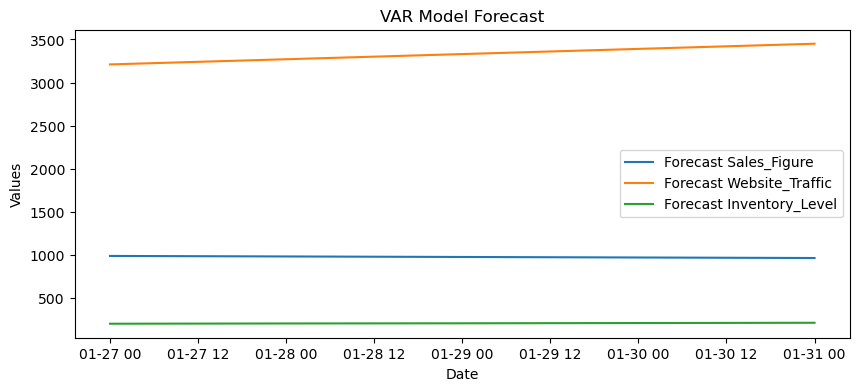

In [34]:
# using relevant columns
data_var = df[['Sales_Figure', 'Website_Traffic', 'Inventory_Level']].dropna()

# Fit the VAR model
model = VAR(data_var)
model_fit = model.fit(maxlags=5, ic='aic')  # Automatic lag selection based on AIC

# Print model summary
print(model_fit.summary())

# Prepare for forecasting
n_forecast_steps = 5  
forecast_data = data_var.values[-model_fit.k_ar:]  

# Generate forecasts
forecast = model_fit.forecast(y=forecast_data, steps=n_forecast_steps)

# Convert the forecast to a DataFrame for better visualization
forecast_df = pd.DataFrame(forecast, columns=data_var.columns)
forecast_df.index = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=n_forecast_steps, freq='D')

print(forecast_df)
plt.figure(figsize=(10, 4))
for column in forecast_df.columns:
    plt.plot(forecast_df.index, forecast_df[column], label=f'Forecast {column}')

plt.title('VAR Model Forecast')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.show()


### Overview:
The VAR (Vector Autoregression) model forecast shows predictions for three variables: Sales_Figure, Website_Traffic, and Inventory_Level. The x-axis represents the date, and the y-axis represents the values of each variable.

#### Observations:
* Sales_Figure: The forecast for Sales_Figure shows a slight upward trend over the predicted period. This suggests a potential increase in sales in the coming days.
* Website_Traffic: The forecast for Website_Traffic also indicates a slight upward trend, suggesting a potential increase in website visitors.
* Inventory_Level: The forecast for Inventory_Level remains relatively stable, suggesting that the inventory levels are expected to remain consistent.

#### Potential Relationships:
While the VAR model captures the interdependencies between the variables, the forecast alone doesn't provide direct evidence of cause-and-effect relationships. However, based on the trends observed in the forecast, it's possible that:
* An increase in website traffic might lead to a corresponding increase in sales.
Changes in sales figures could influence inventory levels.

#### Further Analysis:
* To gain a deeper understanding of the relationships between these variables and the factors driving their behavior, additional analysis might be necessary. This could include:
* Examining historical data and trends to identify patterns and correlations.
* Considering external factors that might influence the variables, such as economic conditions, marketing campaigns, or seasonal trends.
* Conducting statistical tests to quantify the relationships between the variables.